In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from stratx import featimp
from stratx.partdep import *
from rfpimp import plot_importances
import rfpimp

import shap

%config InlineBackend.figure_formats = ['svg','png']


In [2]:
def synthetic_poly_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    # df['x3'] = df['x1']  # copy x1
    # multiply coefficients x each column (var) and sum along columns
    df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    #TODO add noise
    terms = [f"{coeff[i]:.1f}x_{i+1}" for i in range(p)]
    eqn = "y = " + '+'.join(terms)
    return df, coeff, eqn

In [67]:
def synthetic_poly2_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    coeff = np.array([5, 2, 10])
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    # df['x3'] = df['x1']  # copy x1
    # multiply coefficients x each column (var) and sum along columns
    # df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    df['y'] = 5*df['x1'] - 3*df['x2'] + 3*df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 - 3 x_2 + 3 x_3^2"

In [69]:
palette = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
    "#ffff99", 
    "#b15928"
]
def plot_all_PD(X,y,eqn=None,min_samples_leaf=5):
    fig, ax = plt.subplots(1,1)
    for i,colname in enumerate(X.columns):
        plot_stratpd(X, y, colname, 'y', ax=ax, min_samples_leaf=min_samples_leaf,
                     show_slope_lines=False,
                     pdp_marker_color=palette[i])
#     uniq_x = np.array(sorted(np.unique(X[:,0])))
#     ax2 = ax.twinx()
    record_x = range(len(y))
    record_x = (record_x - np.mean(record_x)) / np.std(record_x)
    ax.plot(record_x, y, lw=.3, c='k', label='marginal $y$ vs $x^{(i)}$')
    if eqn is not None:
        plt.title(f"${eqn}$")
    plt.tight_layout()
    plt.legend()
    plt.show()

In [70]:
def compare_imp(X,y,eqn):
    fig, axes = plt.subplots(1,3,figsize=(7,2))

    I = featimp.importances(X, y)
    plot_importances(I, imp_range=(0,1),ax=axes[0])

    perm_I = rfpimp.importances(rf,X,y)
    plot_importances(perm_I,ax=axes[1])
    drop_I = rfpimp.dropcol_importances(rf,X,y)
    plot_importances(drop_I,ax=axes[2])

    axes[0].set_title("Strat Imp")
    axes[1].set_title(f"${eqn}$")
    axes[2].set_title("Drop column")
    plt.show()

## Synthetic degree 1 polynomial

In [71]:
df, coeff, eqn = synthetic_poly_data(500,3)
df.head()

,x1,x2,x3,y
0,1.2,2.7,9.1,93.162580
1,7.8,8.9,1.5,82.793684
2,7.1,4.2,1.4,69.619879
3,9.9,4.3,3.5,108.338222
4,2.3,7.2,2.4,48.805271


In [72]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)

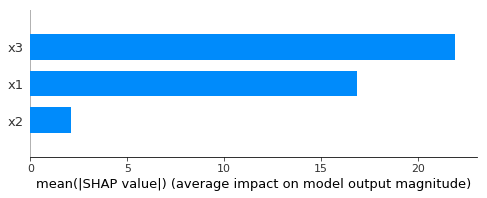

In [73]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

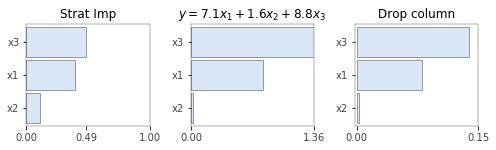

In [74]:
compare_imp(X,y,eqn)

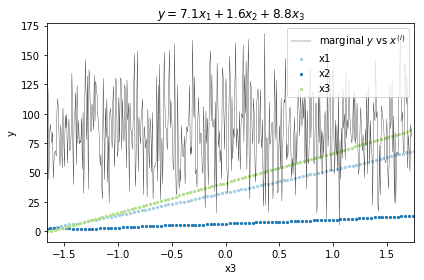

In [75]:
plot_all_PD(X,y,eqn)

## Synthetic degree 2 polynomial

In [76]:
df, coeff, eqn = synthetic_poly2_data(500,3)
df.head()

,x1,x2,x3,y
0,2.9,5.4,4.7,64.57
1,5.8,8.5,0.1,3.53
2,2.1,1.5,0.9,8.43
3,9.9,2.3,4.9,114.63
4,1.3,9.3,7.1,129.83


In [77]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)

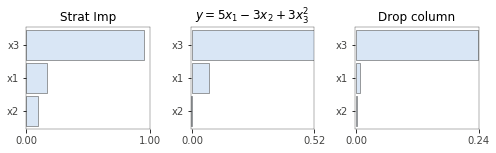

In [78]:
compare_imp(X,y,eqn)

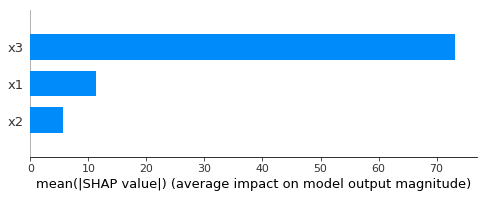

In [79]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

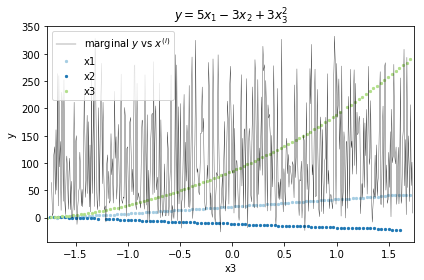

In [80]:
plot_all_PD(X,y,eqn)

## Synthetic degree 2 polynomial with duplicated column x_3

In [131]:
def synthetic_poly2dup_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    coeff = np.array([5, 2, 10])
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    df['x3'] = df['x1']  # copy x1 into x3
    # multiply coefficients x each column (var) and sum along columns
    # df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    df['y'] = 5*df['x1'] + 3*df['x2'] + df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 + 3 x_2 + x_3^2 where x_3 = x_1"

In [132]:
df, coeff, eqn = synthetic_poly2dup_data(500,3)
df.head()

,x1,x2,x3,y
0,1.3,8.7,1.3,34.29
1,3.2,3.1,3.2,35.54
2,5.4,8.0,5.4,80.16
3,6.5,9.3,6.5,102.65
4,0.9,0.8,0.9,7.71


In [133]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)

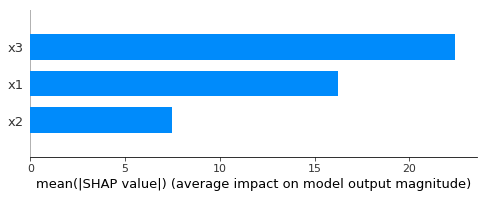

In [134]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

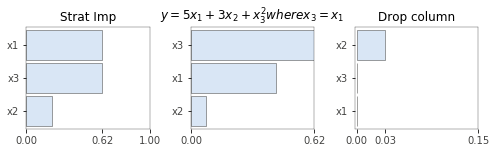

In [135]:
compare_imp(X,y,eqn)

## Synthetic degree 2 polynomial with sine

In [98]:
def synthetic_poly2_sine_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    df['y'] = 5*df['x1'] + 15*np.sin(df['x2']+(n/2)*(2*np.pi)/n) + df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 + 15 sin(x_2) + x_3^2"

In [99]:
df, coeff, eqn = synthetic_poly2_sine_data(500,3)
df.head()

,x1,x2,x3,y
0,8.5,4.7,10.0,157.498849
1,1.3,5.6,4.4,35.329000
2,7.4,1.6,6.4,62.966396
3,1.7,0.3,3.4,15.627197
4,0.3,5.5,4.6,33.243105


In [100]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)

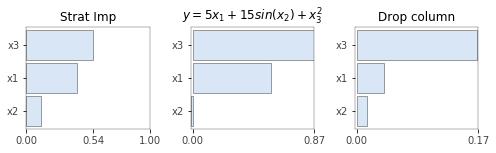

In [101]:
compare_imp(X,y,eqn)

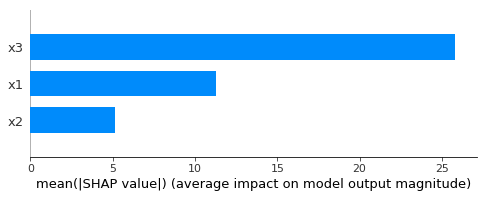

In [102]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

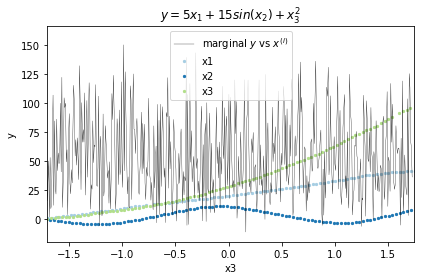

In [103]:
plot_all_PD(X,y,eqn)

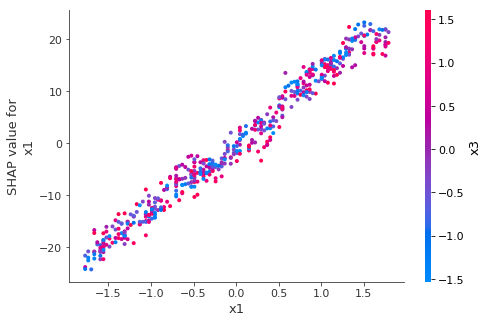

In [104]:
shap.dependence_plot("x1", shap_values, X)

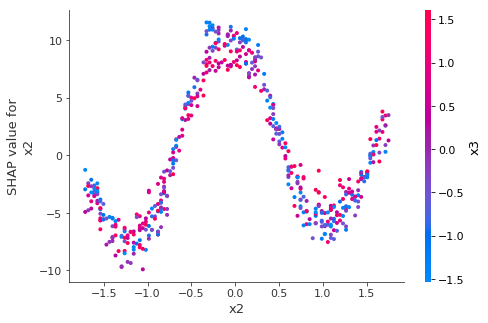

In [105]:
shap.dependence_plot("x2", shap_values, X)

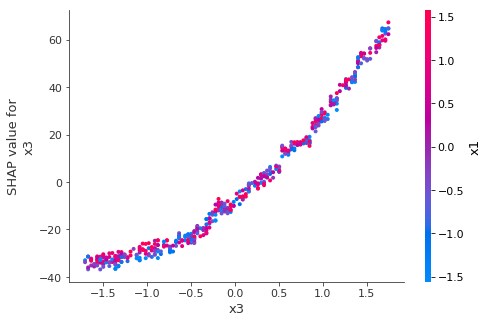

In [106]:
shap.dependence_plot("x3", shap_values, X)

# Playground

(-2, 2)

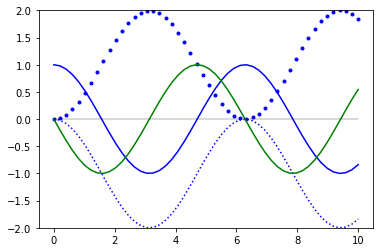

In [29]:
x = np.linspace(0,10)
y = np.cos(x)
y_ = -np.sin(x)

plt.plot(x,y, c='blue')
plt.plot(x,y-y[0], ':', c='blue')
plt.plot(x,np.abs(y-y[0]), '.', c='blue')
plt.plot(x,y_, c='green')
# plt.plot(x,np.abs(y_), ':', c='green')
plt.plot([0,10], [0,0], c='k', lw=.3)
plt.ylim(-2,2)

[<matplotlib.lines.Line2D at 0x1c19e38ef0>]

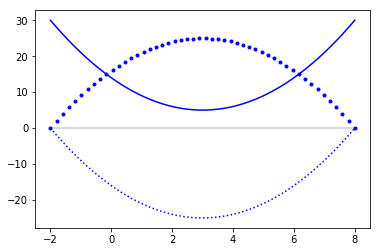

In [36]:
x = np.linspace(-2,8)
y = (x-3)**2+5
plt.plot(x,y, c='blue')
plt.plot(x,y-y[0], ':', c='blue')
plt.plot(x,np.abs(y-y[0]), '.', c='blue')
plt.plot([-2,8], [0,0], c='k', lw=.3)

[<matplotlib.lines.Line2D at 0x1c1b3d3c18>]

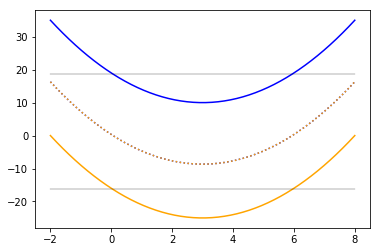

In [66]:
x = np.linspace(-2,8)
y = (x-3)**2+10
y_ = (x-3)**2
#shift = np.mean(y) - np.mean(y_)
plt.plot(x,y, c='blue')
plt.plot(x,y-np.mean(y), ':', c='blue')
plt.plot(x,y-y[0], c='orange')
plt.plot(x,y-y[0]-np.mean(y-y[0]), ':', c='orange')
# plt.plot(x,y_-np.mean(y_), ':', c='orange')
plt.plot([-2,8], [np.mean(y),np.mean(y)], c='k', lw=.3)
plt.plot([-2,8], [np.mean(y-y[0]),np.mean(y-y[0])], c='k', lw=.3)

In [53]:
np.mean(y), np.mean(y_), np.mean(y) - np.mean(y_), y[0]

(18.673469387755105, -0.1741628295578003, 18.847632217312906, 35.0)

In [ ]:
# ok so subtract mean of y and PD of y then measure/compare area under curve